# Машинное обучение в бизнесе
## Урок 2. Преобразование признаков

Обозначения:
* $p$ — глубина истории, сколько измерений назад учитываем в моделях
* $h$ — горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

### Задание 1

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по `data_exp_1` с горизонт прогноза $h=1$ и $h=10$ по образцу из примера для обработки ряда "цена Нефти". Учитывать только глубину истории при $p=3$.

**Решение**

In [80]:
data = pd.read_csv("my_PJME_MW.csv", index_col=[0], parse_dates=[0])
data.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [15]:
d_data = data.resample("D").mean()

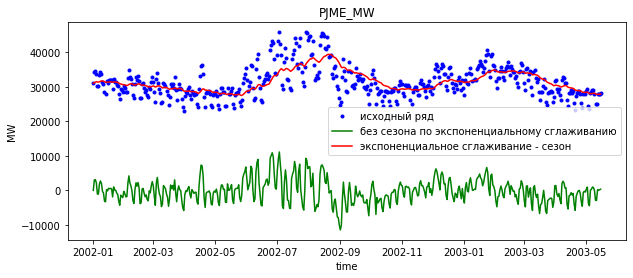

In [77]:
data_exp_1 = exponential_smoothing(d_data["PJME_MW"], 0.05)
plt.figure(figsize=(10, 4))
plt.plot(d_data.index[:500], d_data["PJME_MW"].values[:500], ".b", label="исходный ряд")

plt.plot(
    d_data.index[:500],
    d_data["PJME_MW"].values[:500] - data_exp_1[:500],
    color="green",
    label="без сезона по экспоненциальному сглаживанию",
)

plt.plot(
    d_data.index[:500],
    data_exp_1[:500],
    color="red",
    label="экспоненциальное сглаживание - сезон",
)

plt.xlabel("time")
plt.ylabel("MW")
plt.legend()
plt.title("PJME_MW")
plt.show()

In [79]:
df = pd.DataFrame(data_exp_1, index=d_data.index)
# добавили историю на глубину 3 измерения от текущего (р=3)
df["t"] = 0
df.iloc[1:, 1] = df.iloc[:-1, 0].values
df["t1"] = 0
df.iloc[2:, 2] = df.iloc[:-2, 0].values
df["t2"] = 0
df.iloc[3:, 3] = df.iloc[:-3, 0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df["exp_0_01"] = exponential_smoothing(df[0], 0.01)
df["exp_0_03"] = exponential_smoothing(df[0], 0.03)
df["exp_0_08"] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df["diff1"] = 0
df["diff1"].iloc[1:] = df.iloc[1:, 0].values - df.iloc[:-1, 0].values


df.head(3)

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.00000,0.0,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.00000,0.0,31082.329532,31085.510334,31093.462341,159.040127
2002-01-03,31403.384044,31239.779257,31080.73913,0.0,31085.540077,31095.046546,31118.256077,163.604787


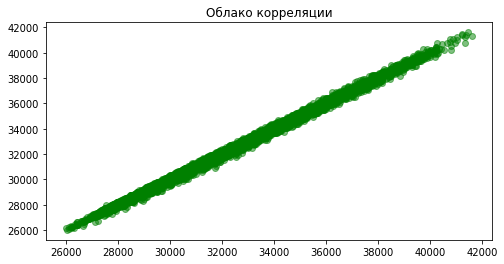

In [61]:
plt.figure(figsize=(8, 4))
plt.scatter(
    df[0:].iloc[1:, 0], df[0:].iloc[:-1, 0].values, c="g", alpha=0.5,
)
plt.title("Облако корреляции")
plt.show()

In [62]:
def split_data_b(data, split_date):
    return (
        data.loc[data.index <= split_date].copy(),
        data.loc[data.index > split_date].copy(),
    )

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
)
from sklearn.preprocessing import StandardScaler

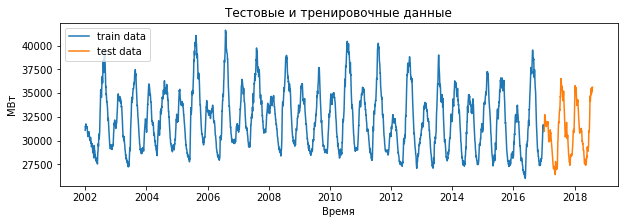

In [96]:
train_b, test_b = split_data_b(df, "2017-01-01")

plt.figure(figsize=(10, 3))
plt.xlabel("Время")
plt.ylabel("МВт")
plt.plot(train_b.index, train_b[df.columns[0]], label="train data")
plt.plot(test_b.index, test_b[df.columns[0]], label="test data")
plt.title("Тестовые и тренировочные данные")
plt.legend()
plt.show()

In [98]:
h = 1
X_train_b1 = train_b.iloc[:-h, :]
y_train_b1 = train_b[df.columns[0]].values[h:]
X_test_b1 = test_b.iloc[:-h, :]
y_test_b1 = test_b[df.columns[0]].values[h:]

model_gb1 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb1.fit(X_train_b1, y_train_b1)
X_test_pred_gb1 = model_gb1.predict(X_test_b1)

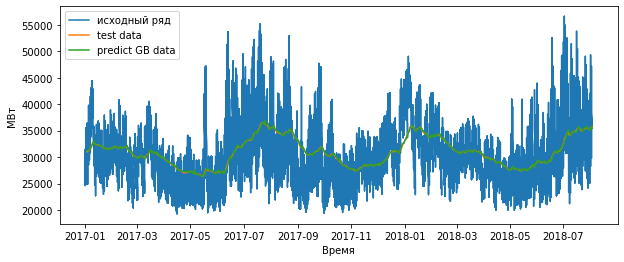

In [99]:
plt.figure(figsize=(10, 4))

plt.xlabel("Время")
plt.ylabel("МВт")
plt.plot(
    data.loc["2017-01-01":].index,
    data.loc["2017-01-01":]["PJME_MW"],
    label="исходный ряд",
)
plt.plot(test_b.index[h:], y_test_b1, label="test data")
plt.plot(test_b.index[h:], X_test_pred_gb1, label="predict GB data")

plt.legend()
plt.show()

In [101]:
h = 10
X_train_b10 = train_b.iloc[:-h, :]
y_train_b10 = train_b[df.columns[0]].values[h:]
X_test_b10 = test_b.iloc[:-h, :]
y_test_b10 = test_b[df.columns[0]].values[h:]


model_gb10 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb10.fit(X_train_b10, y_train_b10)
X_test_pred_gb10 = model_gb10.predict(X_test_b10)

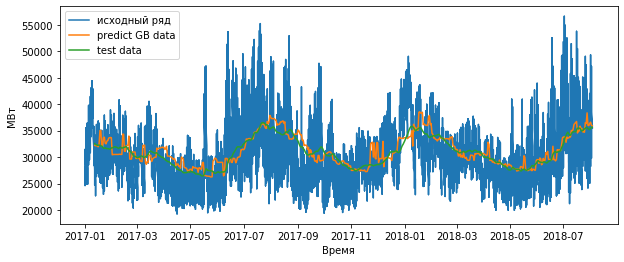

In [102]:
plt.figure(figsize=(10, 4))

plt.xlabel("Время")
plt.ylabel("МВт")
plt.plot(
    data.loc["2017-01-01":].index,
    data.loc["2017-01-01":]["PJME_MW"],
    label="исходный ряд",
)
plt.plot(test_b.index[h:], X_test_pred_gb10, label="predict GB data")
plt.plot(test_b.index[h:], y_test_b10, label="test data")

plt.legend()
plt.show()

### Задание 2

Оцените ошибку модели из п.1 .

**Решение**

In [69]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [103]:
er_g = mean_absolute_percentage_error(y_true=y_test_b1, y_pred=X_test_pred_gb1)

print("ошибка градиентного бустинга при h=1:", er_g, "%")

ошибка градиентного бустинга при h=1: 0.4429472469230937 %


In [104]:
er_g = mean_absolute_percentage_error(y_true=y_test_b10, y_pred=X_test_pred_gb10)

print("ошибка градиентного бустинга :  ", er_g, "%")

ошибка градиентного бустинга :   3.342540006930741 %


### Задание 3

Сделайте вывод о том, как изменилась ошибка модели по значениям $h$.

**Решение**

Модель авторегрессии с горизонтом прогноза 1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.5%.
При интервале прогноза в 10 шагов вперед все стало не так хорошо: почти 3.5% ошибки по основной линии прогноза.

### Задание 4

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).    
    б) Количество денег, которые тратят покупатели в интернет магазине.    
    в) Вес растущего котенка.    
    г) Прирост объема деревьев в лесу от времени

**Решение:**

    a) нестационарный (из-за сезонности), без тренда (если не считать глобальное потепление/похолодание), с сезоном, без циклов
    б) нестационарный (из-за тренда), с трендом (рост бизнеса), с сезоном, с циклом (экономические периоды)
    в) нестационарный (из-за тренда), с трендом (до 2 лет), без сезона, без циклов
    г) нестационарный (из-за тренда), с трендом (лес всегда растет, если нет человеческого фактора), с сезоном (увеличение только в весенне-летний период), без циклов

### Задание5

Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)

**Решение**

b